# Start: Analysiere Daten

In [14]:
# import initial_data.csv
import pandas as pd
import numpy as np

from feasibility import is_feasible

# import data from csv file
def import_data():
    data = pd.read_csv('initial_data.csv')
    return data

data = import_data()

In [15]:
# import queried data
import csv
import re

def read_csv_file(file_path):
    # Initialisiere eine leere Liste, um die bereinigten Daten zu speichern
    cleaned_data = []

    # Lese die CSV-Datei
    with open(file_path, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=';')  # Annahme: Semikolon als Trennzeichen
        for row in reader:
            # Verbinde die Zeilenelemente mit einem Komma, um das Trennzeichen zu vereinheitlichen
            unified_row = ','.join(row)
            # Ersetze mehrere aufeinander folgende Kommas durch ein einzelnes Komma
            unified_row = re.sub(r',+', ',', unified_row)
            # Teile die vereinheitlichte Zeile nach dem Komma auf
            split_row = unified_row.split(',')
            # Entferne die ersten zwei Parameter
            cleaned_row = split_row[1:]
            # Füge die bereinigte Zeile der Liste hinzu
            cleaned_data.append(cleaned_row)

    return cleaned_data

# Beispiel: Daten aus "input.csv" einlesen
input_file_path = "querys_ForcePush.csv"
cleaned_data = read_csv_file(input_file_path)

# Bereinigte Daten als pandas DataFrame speichern mit erster Zeile als Spaltennamen
df_queried = pd.DataFrame(cleaned_data[1:], columns=cleaned_data[0])


# Bereinigte Daten ausgeben
# print(df_queried)
# df_queried = pd.DataFrame(cleaned_data)

In [16]:
def add_data(data, queried_data):
    # add queried data (without cost) to initial data
    data = pd.concat([data, queried_data.iloc[:, :13]], axis=0)
    return data

data = add_data(data, df_queried)
# print(data)

data = data.astype(float)
print(data.columns)
# drop PM2 column
data = data.drop(columns=['PM 2'])
print(data.columns)
data = data.reset_index(drop=True)

Index(['Engine speed', 'Engine load', 'Railpressure', 'Air supply',
       'Crank angle', 'Intake pressure', 'Back pressure', 'Intake temperature',
       'NOx', 'PM 1', 'CO2', 'PM 2', 'Pressure cylinder'],
      dtype='object')
Index(['Engine speed', 'Engine load', 'Railpressure', 'Air supply',
       'Crank angle', 'Intake pressure', 'Back pressure', 'Intake temperature',
       'NOx', 'PM 1', 'CO2', 'Pressure cylinder'],
      dtype='object')


### Functions to handle data

In [17]:
def get_input_data(data, row):
    x1, x2, x3, x4, x5, x6, x7, x8 = data.iloc[row, 0], data.iloc[row, 1], data.iloc[row, 2], data.iloc[row, 3], data.iloc[row, 4], data.iloc[row, 5], data.iloc[row, 6], data.iloc[row, 7]
    return x1, x2, x3, x4, x5, x6, x7, x8

def get_output_data(data, row):
    x1, x2, x3, x4 = data.iloc[row, 8], data.iloc[row, 9], data.iloc[row, 10], data.iloc[row, 11]
    return x1, x2, x3, x4, x5

def get_critical_output_data(data, i):
    x1, x2 = data.iloc[i, 9], data.iloc[i, 11],
    return x1, x2

In [18]:
# put column names into a list
column_names = data.columns.values
#print(column_names)
inputs = column_names[0:8]
print("Inputs: ", inputs)
outputs = column_names[8:12]
print("Outputs: ", outputs)

Inputs:  ['Engine speed' 'Engine load' 'Railpressure' 'Air supply' 'Crank angle'
 'Intake pressure' 'Back pressure' 'Intake temperature']
Outputs:  ['NOx' 'PM 1' 'CO2' 'Pressure cylinder']


### Classify safe data

In [19]:
# classify data safety
# Check if outputs are in safe range
# PM 1 < 6, (PM 2 < 16), Pressure cylinder < 160

def label_safe(data):
    safe = []
    for i in range(len(data)):
        x9, x10  = get_critical_output_data(data, i)
        if x9 < 6:
            if x10 < 160:
                safe.append(0)
            else:
                safe.append(2)
        else:
            if x10 < 160:
                safe.append(1)
            else:
                safe.append(2)
    data['safe'] = safe
    return data

data = label_safe(data)
print(data['safe'])

0      0
1      0
2      0
3      0
4      0
      ..
158    0
159    2
160    0
161    0
162    0
Name: safe, Length: 163, dtype: int64


In [20]:
# train a model to predict unsafe output
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

# split data into training and testing data

# Schritt 1: Feature-Importance bestimmen
X = data[inputs]
y = data['safe']
#print(y.head())
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)
feature_importances = model.feature_importances_
print(feature_importances)

# Schritt 2: Datenpunkte basierend auf Feature-Wichtigkeiten anpassen
adjustedData = X * feature_importances

X_train, X_test, y_train, y_test = train_test_split(adjustedData, y, test_size=0.3, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train = X_train * feature_importances
# count number of False values in y_train and y_test
print("Number of unsafe in training: ",(len(y_train[y_train == 1])+len(y_train[y_train == 2])))
print("Number of unsafe in testing: ",(len(y_test[y_test == 1])+len(y_test[y_test == 2])))

# train a random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# predict on test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

[0.09840702 0.17714962 0.07184635 0.06055304 0.20597386 0.20662303
 0.05358492 0.12586216]
Number of unsafe in training:  11
Number of unsafe in testing:  3
Accuracy: 0.8979591836734694


## Import Submission-Data

In [21]:
# import submission data
submission_data = pd.read_csv('submission.csv')
# print(submission_data)
# rename columns
submission_data.columns = column_names[:8]
print(submission_data.columns)
print(submission_data.head())

Index(['Engine speed', 'Engine load', 'Railpressure', 'Air supply',
       'Crank angle', 'Intake pressure', 'Back pressure',
       'Intake temperature'],
      dtype='object')
   Engine speed  Engine load  Railpressure  Air supply  Crank angle  \
0   2079.242896    15.249091   1059.615682  330.175905    -6.221489   
1    820.449848   120.353061   1271.158901  487.645261     3.472795   
2   1639.495961    83.300535   1601.817725  634.526366    -0.793814   
3   1260.782708   101.754809    828.257891  392.354655     0.122483   
4    903.744741    30.628885   1650.039653  602.760187     6.470709   

   Intake pressure  Back pressure  Intake temperature  
0      1126.065139    3432.348069           73.435318  
1      2084.175034    1985.181081           42.863344  
2      1268.308573    3234.188679           50.848907  
3      2492.140669    1466.726258           72.014909  
4      2631.683432    3797.403335           56.749198  


In [22]:
new_data = pd.DataFrame(submission_data, columns=inputs)

# check feasibleData safety via classifier
X = new_data
print(X.head())
safeDataPoints = []
y_pred = clf.predict(X)
print(y_pred)

for i in range(len(y_pred)):
    if y_pred[i] == 0:
        #append the corrsponding data point to safeDataPoints
        safeDataPoints.append(X.iloc[i])
        
print(len(y_pred[y_pred == 0]))
print(len(y_pred))
# print(len(safeDataPoints) == len(y_pred[y_pred == 0]))

   Engine speed  Engine load  Railpressure  Air supply  Crank angle  \
0   2079.242896    15.249091   1059.615682  330.175905    -6.221489   
1    820.449848   120.353061   1271.158901  487.645261     3.472795   
2   1639.495961    83.300535   1601.817725  634.526366    -0.793814   
3   1260.782708   101.754809    828.257891  392.354655     0.122483   
4    903.744741    30.628885   1650.039653  602.760187     6.470709   

   Intake pressure  Back pressure  Intake temperature  
0      1126.065139    3432.348069           73.435318  
1      2084.175034    1985.181081           42.863344  
2      1268.308573    3234.188679           50.848907  
3      2492.140669    1466.726258           72.014909  
4      2631.683432    3797.403335           56.749198  
[0 2 2 ... 2 2 2]
7876
57892


### Find significant data based on complete real data

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Schritt 1: Feature-Importance bestimmen
complData = data
X = complData[inputs]
y = complData[outputs]
#print(y.head())
model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)
feature_importances = model.feature_importances_
print(feature_importances)

# Schritt 2: Datenpunkte basierend auf Feature-Wichtigkeiten anpassen
adjustedData = X * feature_importances

# Schritt 3: Clusteranalyse durchführen mit angepassten Daten
scaler = StandardScaler()
scaledAdjustedData = scaler.fit_transform(adjustedData)


# elbow method to determine number of clusters
# from matplotlib import pyplot as plt
# inertia = []
# for i in range(1, 10):
#     kmeans = KMeans(n_clusters=i)
#     kmeans.fit(scaledAdjustedData)
#     print(i, kmeans.inertia_)
#     inertia.append(kmeans.inertia_)
# plt.plot(range(1, 10), inertia)
# plt.show()


kmeans = KMeans(n_clusters=6)
clusterLabels = kmeans.fit_predict(scaledAdjustedData)

# Schritt 4: Repräsentative Datenpunkte auswählen
# (Beispiel zeigt, wie man die Clusterlabels zu den ursprünglichen Daten hinzufügt und repräsentative Punkte auswählt)
# freeData = submission_data.droprows(), wenn die Datenpunkte in data enthalten sind

submission_data['cluster'] = kmeans.predict(scaler.transform(submission_data[inputs] * feature_importances))
new_points = []
for cluster in range(6):
    cluster_data = submission_data[submission_data['cluster'] == cluster]
    cluster_center = kmeans.cluster_centers_[cluster]
    # Berechne die Distanz unter Berücksichtigung der Feature-Wichtigkeiten
    closest_points, _ = pairwise_distances_argmin_min(cluster_data[inputs] * feature_importances, [cluster_center])
    print(len(closest_points))
    # get the first 3 closest points
    if len(closest_points) > 0:
        new_points.append(cluster_data.iloc[closest_points[0]])
new_points = pd.DataFrame(new_points)
print(new_points)

new_data = pd.DataFrame(new_points, columns=inputs)

# check feasibleData safety via classifier
X = new_data
print(X.head())
safeDataPoints = []
y_pred = clf.predict(X)
print(y_pred)

for i in range(len(y_pred)):
    if y_pred[i] == 0:
        #append the corrsponding data point to safeDataPoints
        safeDataPoints.append(X.iloc[i])
        

print(len(safeDataPoints) == len(y_pred[y_pred == 0]))

# print as formatted string seperated by semi-colon
def print_data(data):
    for i in range(len(data)):
        print(';'.join(map(str, data[i])))
    return

print_data(safeDataPoints)

[0.02127933 0.56250639 0.06322219 0.10100394 0.08436348 0.06951074
 0.03342065 0.06469327]
10568
3443
10286
6936
16833
9826
    Engine speed  Engine load  Railpressure  Air supply  Crank angle  \
7    1813.757527    29.679124   1504.850622  978.269310     1.333675   
9    1129.866907    21.170713    707.482600  433.390575     4.217226   
0    2079.242896    15.249091   1059.615682  330.175905    -6.221489   
11    988.948241    38.966357   1471.254208  179.178156     0.869117   
4     903.744741    30.628885   1650.039653  602.760187     6.470709   
1     820.449848   120.353061   1271.158901  487.645261     3.472795   

    Intake pressure  Back pressure  Intake temperature  cluster  
7       1736.865724    3565.584398           69.051095      0.0  
9       1365.237672    1023.147222           62.236283      1.0  
0       1126.065139    3432.348069           73.435318      2.0  
11      1186.477575    2334.776826           51.094320      3.0  
4       2631.683432    3797.403335       

## Get equally distributed among Speed and Load new data points to query

In [24]:
# get 10 new data points from submission which are equally distributed among 'Eingine Speed' and 'Engine Load'
# and are feasible
def get_new_data_points(data, nmbOfPoints):
    min_speed = data['Engine speed'].min()
    max_speed = data['Engine speed'].max()
    min_load = data['Engine load'].min()
    max_load = data['Engine load'].max()

    speed_ranges = np.linspace(min_speed, max_speed, nmbOfPoints + 1)
    load_ranges = np.linspace(min_load, max_load, nmbOfPoints + 1)

    data['SpeedRange'] = pd.cut(data['Engine speed'], bins=speed_ranges, include_lowest=True, labels=False)
    data['LoadRange'] = pd.cut(data['Engine load'], bins=load_ranges, include_lowest=True, labels=False)

    selected_data = []

    for speed_range in range(nmbOfPoints):
        for load_range in range(nmbOfPoints):
            data_in_range = data[(data['SpeedRange'] == speed_range) & (data['LoadRange'] == load_range)]
            if not data_in_range.empty:
                # Repräsentativen Datenpunkt auswählen
                # 1. Iteration: Wähle den ersten Wert
                # selected_data.append(data_in_range.iloc[0])
                # 2. Iteration: wähle den ersten Wert, der oberen 50% der Datenpunkte
                #index = len(data_in_range) // 2
                # 3. Iteration: wähle den ersten Wert, der oberen 25% der Datenpunkte
                index = len(data_in_range) // 4
                selected_data.append(data_in_range.iloc[index])
                print(len(data_in_range))

    return pd.DataFrame(selected_data)

new_data = get_new_data_points(submission_data, 5)
#print(new_data_points)
new_data = pd.DataFrame(new_data, columns=inputs)

# check feasibleData safety via classifier
X = new_data
print(X.head())
safeDataPoints = []
y_pred = clf.predict(X)
print(y_pred)

for i in range(len(y_pred)):
    if y_pred[i] == 0:
        #append the corrsponding data point to safeDataPoints
        safeDataPoints.append(X.iloc[i])
        

print(len(safeDataPoints) == len(y_pred[y_pred == 0]))

# print as formatted string seperated by semi-colon
def print_data(data):
    for i in range(len(data)):
        print(';'.join(map(str, data[i])))
    return

print_data(safeDataPoints)
# safeDataPoints.append(X[i])

4342
4080
2940
961
10
3352
3211
2507
1595
406
2996
2918
2515
1829
652
2946
2936
2842
2399
754
2861
2823
2813
2816
388
       Engine speed  Engine load  Railpressure  Air supply  Crank angle  \
14534    876.770787    14.256479   1103.803300  104.357600     7.005310   
14608    895.641908    37.415300    632.983981  184.470993    -5.621279   
14137    749.620906    79.497060    823.577378  498.609450     0.383693   
14183    838.770382   108.043994   1679.903581  601.945226    -2.145304   
10449    954.239875   136.291092   1222.002292  436.051906     1.341467   

       Intake pressure  Back pressure  Intake temperature  
14534      2509.602266    2730.620025           55.634229  
14608      1167.817756    1887.611903           61.693995  
14137      2721.254457    1209.064551           51.293917  
14183      2000.497975    2735.987249           46.376669  
10449      2527.732454    2476.203707           61.039405  
[0 1 2 1 2 1 1 1 1 2 0 1 1 1 1 0 1 2 2 2 2 2 2 2 2]
True
876.7707869410

In [25]:
# put column names into a list
column_names = data.columns.values
#print(column_names)
inputs = column_names[0:8]
print("Inputs: ", inputs)
outputs = column_names[8:13]
print("Outputs: ", outputs)

Inputs:  ['Engine speed' 'Engine load' 'Railpressure' 'Air supply' 'Crank angle'
 'Intake pressure' 'Back pressure' 'Intake temperature']
Outputs:  ['NOx' 'PM 1' 'CO2' 'Pressure cylinder' 'safe']


                    Engine speed  Engine load
Engine speed            1.000000     0.056155
Engine load             0.056155     1.000000
Railpressure            0.673487     0.399385
Air supply              0.576297     0.473938
Crank angle             0.290228    -0.363669
Intake pressure         0.196509     0.613065
Back pressure           0.255827     0.449722
Intake temperature      0.605193    -0.039733


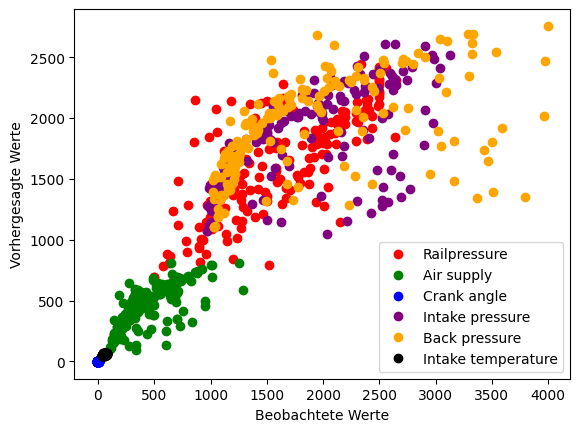

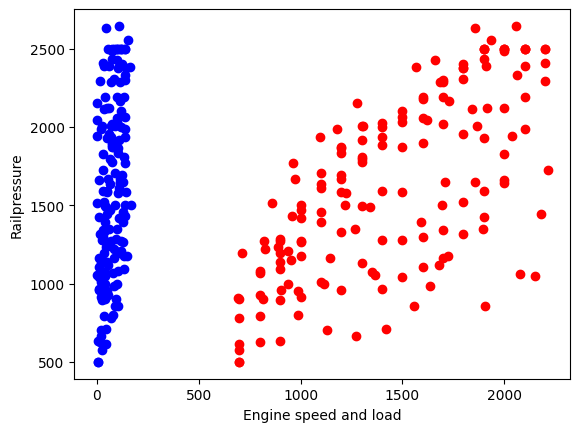

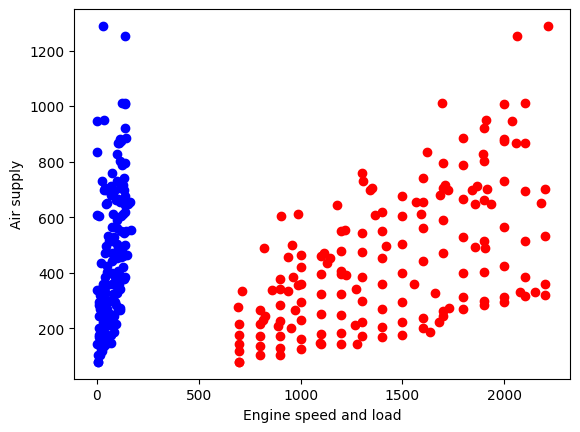

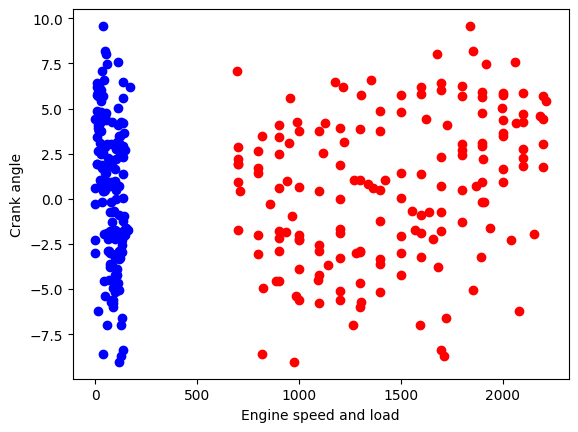

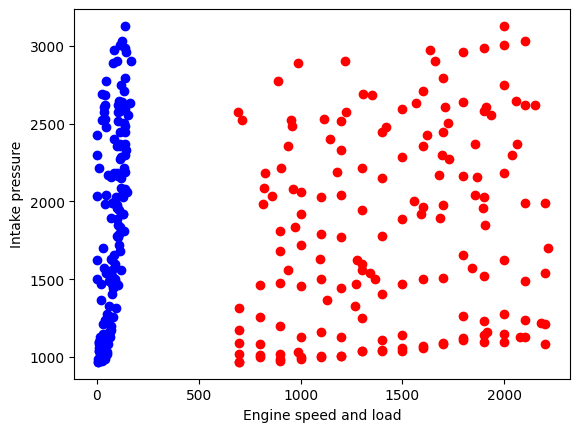

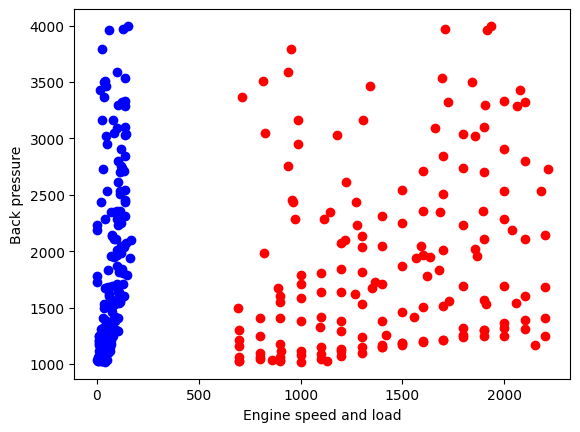

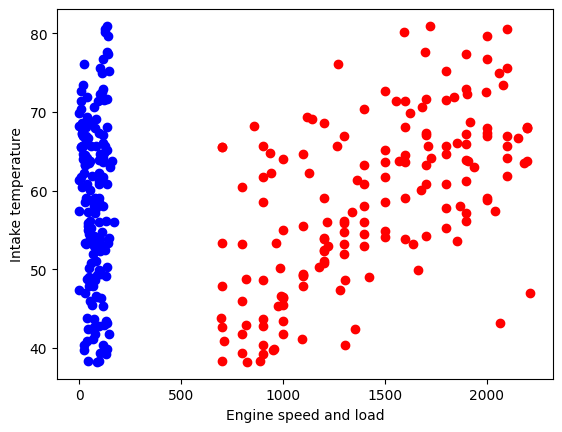

In [26]:
import pandas as pd
import statsmodels.api as sm

# Angenommen, df ist Ihr DataFrame mit den Spalten 'Speed', 'Load' und anderen Input-Parametern
# df erste 8 Spalten von data
df = data.iloc[:, 0:8]

# Schritt 2: Korrelationsanalyse
correlation_matrix = df.corr()
print(correlation_matrix[['Engine speed', 'Engine load']])

# Schritt 3: Multivariate Regression für einen Parameter 'Param1' als abhängige Variable
X = df[['Engine speed', 'Engine load']]  # Unabhängige Variablen
X = sm.add_constant(X)  # Fügt eine Konstante hinzu, um den Achsenabschnitt zu berücksichtigen
y_RP = df['Railpressure']  # Abhängige Variable
y_AS = df['Air supply']
y_CA = df['Crank angle']
y_IP = df['Intake pressure']
y_BP = df['Back pressure']
y_IT = df['Intake temperature']

model_RP = sm.OLS(y_RP, X).fit()  # Erstellt und passt das Modell an
#print(model_RP.summary())  # Zeigt die Ergebnisse

model_AS = sm.OLS(y_AS, X).fit()  # Erstellt und passt das Modell an
#print(model_AS.summary())  # Zeigt die Ergebnisse

model_CA = sm.OLS(y_CA, X).fit()  # Erstellt und passt das Modell an
#print(model_CA.summary())  # Zeigt die Ergebnisse

model_IP = sm.OLS(y_IP, X).fit()  # Erstellt und passt das Modell an
#print(model_IP.summary())  # Zeigt die Ergebnisse

model_BP = sm.OLS(y_BP, X).fit()  # Erstellt und passt das Modell an
#print(model_BP.summary())  # Zeigt die Ergebnisse

model_IT = sm.OLS(y_IT, X).fit()  # Erstellt und passt das Modell an
#print(model_IT.summary())  # Zeigt die Ergebnisse

# Visualisierung der Ergebnisse
import matplotlib.pyplot as plt

# Erstellen Sie eine Abbildung und Achsen
fig, ax = plt.subplots()

# Erstellen Sie eine Liste von Farben
colors = ['red', 'green', 'blue', 'purple', 'orange', 'black']

# Erstellen Sie eine Liste von Modellen
models = [model_RP, model_AS, model_CA, model_IP, model_BP, model_IT]

# Erstellen Sie eine Liste von Abhängigen Variablen
y = [y_RP, y_AS, y_CA, y_IP, y_BP, y_IT]

# Erstellen Sie eine Liste von Output-Namen
output_names = ['Railpressure', 'Air supply', 'Crank angle', 'Intake pressure', 'Back pressure', 'Intake temperature']

# hinzufügen der daten zu den plots
for i in range(6):
    ax.plot(y[i], models[i].fittedvalues, 'o', color=colors[i], label=output_names[i])

# Erstellen Sie eine Legende
ax.legend()

# Achsenbeschriftungen
ax.set_xlabel('Beobachtete Werte')
ax.set_ylabel('Vorhergesagte Werte')

# Anzeigen des Diagramms
plt.show()

# Plot the dependency of the output variables on the input variables
for i in range(6):
    # make two plots for each output variable
    plt.scatter(df['Engine speed'], y[i], color='red')
    plt.scatter(df['Engine load'], y[i], color='blue')
    plt.xlabel('Engine speed and load')
    plt.ylabel(output_names[i])
    plt.show()



In [27]:
def get_input_data(data, row):
    x1, x2, x3, x4, x5, x6, x7, x8 = data.iloc[row, 0], data.iloc[row, 1], data.iloc[row, 2], data.iloc[row, 3], data.iloc[row, 4], data.iloc[row, 5], data.iloc[row, 6], data.iloc[row, 7]
    return x1, x2, x3, x4, x5, x6, x7, x8

def get_output_data(row):
    x1, x2, x3, x4, x5 = data.iloc[row, 8], data.iloc[row, 9], data.iloc[row, 10], data.iloc[row, 11], data.iloc[row, 12]
    return x1, x2, x3, x4, x5

def get_critical_output_data(i):
    x1, x2, x3 = data.iloc[i, 9], data.iloc[i, 11], data.iloc[i, 12]
    return x1, x2, x3

In [28]:
# show if data row is feasible via the first 8 columns and the function is_feasible
feasible = []
for i in range(len(data)):
    x1, x2, x3, x4, x5, x6, x7, x8 = get_input_data(data, i)
    # print(x1, x2, x3, x4, x5, x6, x7, x8)
    feasible.append(is_feasible(x1, x2, x3, x4, x5, x6, x7, x8))
data['feasible'] = feasible

In [29]:
# Check if outputs are in safe range
# PM 1 < 6, PM 2 < 16, Pressure cylinder < 160

def label_safe(data):
    safe = []
    for i in range(len(data)):
        x9, x10, x11 = get_critical_output_data(i)
        if x9 < 6 and x10 < 16:
            if x11 < 160:
                safe.append(0)
            else:
                safe.append(2)
        else:
            if x11 < 160:
                safe.append(1)
            else:
                safe.append(2)
    data['safe'] = safe
    return data

data = label_safe(data)

In [30]:
unsafe_params = [5, 13, 130]

# label broader safe range
def label_broader_safe(data):
    safe = []
    for i in range(len(data)):
        x9, x10, x11 = get_critical_output_data(i)
        if x9 < unsafe_params[0] and x10 < unsafe_params[1]:
            if x11 < unsafe_params[2]:
                safe.append(0)
            else:
                safe.append(2)
        else:
            if x11 < unsafe_params[2]:
                safe.append(1)
            else:
                safe.append(2)
    data['broader_safe'] = safe
    return data

data = label_broader_safe(data)

# count number of False values in safe column
print((len(data[data['broader_safe'] == 1])+len(data[data['broader_safe'] == 2])))

163


In [31]:
# show unsafe data (safe == 1 or safe == 2)
unsafe_data = data[(data['broader_safe'] == 1) | (data['broader_safe'] == 2)]
print(unsafe_data)

     Engine speed  Engine load  Railpressure  Air supply  Crank angle  \
0      700.000000     7.330000    500.900000   78.375300     1.910000   
1      700.000000    25.850000    577.600000  118.067300     0.940000   
2      700.000000    46.670000    615.800000  144.355700     2.860000   
3      700.000000    69.550000    778.300000  174.177900     2.220000   
4      700.000000    94.330000    900.100000  213.314800    -1.720000   
..            ...          ...           ...         ...          ...   
158   2079.242896    15.249091   1059.615682  330.175905    -6.221489   
159    820.449848   120.353061   1271.158901  487.645261     3.472795   
160   1129.866907    21.170713    707.482600  433.390575     4.217226   
161   1304.030819    75.253024   1780.321534  759.275064    -5.693879   
162   1855.066961    46.327936   2635.164845  646.872681     8.166713   

     Intake pressure  Back pressure  Intake temperature         NOx      PM 1  \
0         967.500000    1027.300000       

In [32]:
# train a model to predict unsafe output
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# split data into training and testing data
X = data[inputs]
y = data['broader_safe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# count number of False values in y_train and y_test
print("Number of unsafe in training: ",(len(y_train[y_train == 1])+len(y_train[y_train == 2])))
print("Number of unsafe in testing: ",(len(y_test[y_test == 1])+len(y_test[y_test == 2])))

print("Parameters for unsafe data: ")
print("PM 1: ", unsafe_params[0])
print("PM 2: ", unsafe_params[1])
print("Pressure cylinder: ", unsafe_params[2])

# train a random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

# predict on test data
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Number of unsafe in training:  130
Number of unsafe in testing:  33
Parameters for unsafe data: 
PM 1:  5
PM 2:  13
Pressure cylinder:  130
Accuracy: 1.0


In [33]:
# submission.csv
def import_submission():
    submission = pd.read_csv('submission.csv')
    return submission

submission = import_submission()

In [34]:
# show if data row is feasible via the first 8 columns and the function is_feasible
feasible = []
for i in range(len(submission)):
    x1, x2, x3, x4, x5, x6, x7, x8 = get_input_data(submission,i)
    # print(x1, x2, x3, x4, x5, x6, x7, x8)
    feasible.append(is_feasible(x1, x2, x3, x4, x5, x6, x7, x8))
submission['feasible'] = feasible

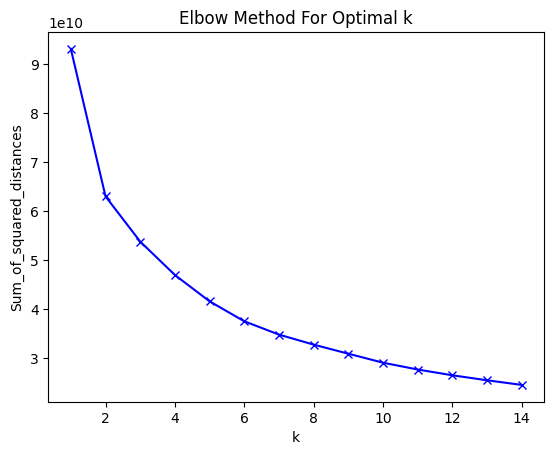

In [35]:
# find the area with the most data points via k-means clustering
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# find number of clusters via elbow method
Sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(submission)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [36]:
# k-Means Clustering durchführen
kmeans = KMeans(n_clusters=6)  # s.o.: 6 Cluster
kmeans.fit(submission)
labels = kmeans.labels_

# Format of print without exponential
np.set_printoptions(suppress=True)

# Größten Cluster finden
# unique, counts = np.unique(labels, return_counts=True)
# groesster_cluster_index = np.argmax(counts)
# groesster_cluster = submission[labels == groesster_cluster_index]

# Bereich des größten Clusters bestimmen (durch Mittelpunkt und Streuung)
# mittelpunkt = kmeans.cluster_centers_[groesster_cluster_index]
# max_distanz = np.max(np.sqrt(np.sum((groesster_cluster - mittelpunkt)**2, axis=1)))

# print(f"Mittelpunkt des größten Clusters: {mittelpunkt}")
# print(f"Maximale Distanz vom Mittelpunkt: {max_distanz}")

# Größe aller Cluster ausgeben mit deren Mittelpunkt und Streuung
allClusters = []
for i in range(6):
    cluster = submission[labels == i]
    mittelpunkt = kmeans.cluster_centers_[i]
    streuung = np.max(np.sqrt(np.sum((cluster - mittelpunkt)**2, axis=1)))
    # get the ranges of the clusters
    min_value = np.min(cluster, axis=0)
    max_value = np.max(cluster, axis=0)
    # calculate the mean and std of each attribute in the cluster
    print(f"Cluster {i}:")
    means = []
    stds = []
    for j in range(8):
        means.append(np.mean(cluster.iloc[:, j]))
        stds.append(np.std(cluster.iloc[:, j]))
        # print(f"Attribute {j}: Mittelwert: {np.mean(cluster.iloc[:, j])}, Standardabweichung: {np.std(cluster.iloc[:, j])}")
    allClusters.append((i, cluster, len(cluster), mittelpunkt, streuung, min_value, max_value, means, stds))
    # print(cluster)
    print(f"Cluster {i}: {len(cluster)} Datenpunkte, Mittelpunkt: {mittelpunkt}, Streuung: {streuung}, Min: + Max: (Range), Mittelwerte, Standardabweichungen")

Cluster 0:
Cluster 0: 9633 Datenpunkte, Mittelpunkt: [1199.95676994   51.72183043 1205.22854029  463.36635218   -0.55391321
 1495.45416746 1789.55341871   56.11091449    1.        ], Streuung: 1522.1848955067026, Min: + Max: (Range), Mittelwerte, Standardabweichungen
Cluster 1:
Cluster 1: 9676 Datenpunkte, Mittelpunkt: [1721.57465104   80.71918956 1730.29687811  668.03961281    0.31388519
 2623.69848735 3285.89858296   58.24105403    1.        ], Streuung: 1440.1418517935688, Min: + Max: (Range), Mittelwerte, Standardabweichungen
Cluster 2:
Cluster 2: 9987 Datenpunkte, Mittelpunkt: [1209.55686936   63.00672727 1196.32173026  477.77132689   -0.53596081
 2567.64067851 1894.00268736   56.37798553    1.        ], Streuung: 1420.4676760810412, Min: + Max: (Range), Mittelwerte, Standardabweichungen
Cluster 3:
Cluster 3: 11017 Datenpunkte, Mittelpunkt: [1030.37171798   56.49749024 1093.21074538  413.19091975   -0.81319516
 1974.61423063 3323.81285048   55.70875654    1.        ], Streuung: 13

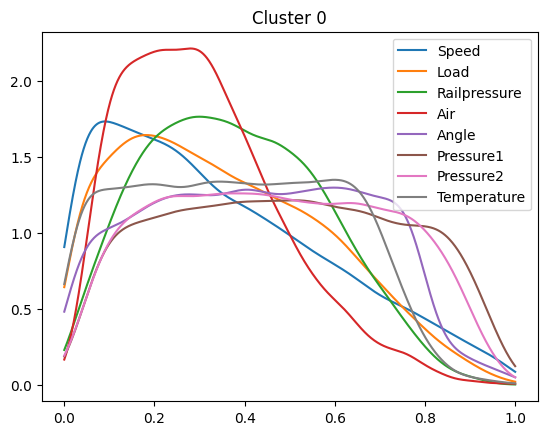

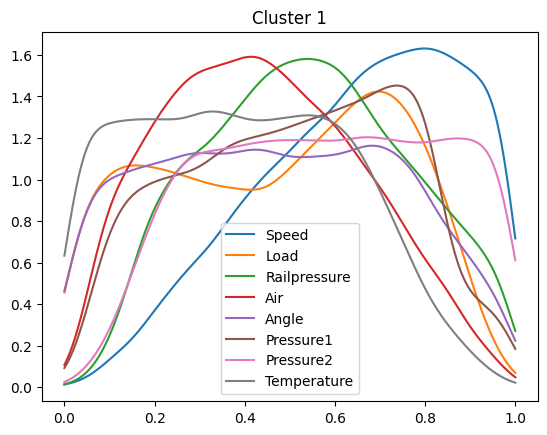

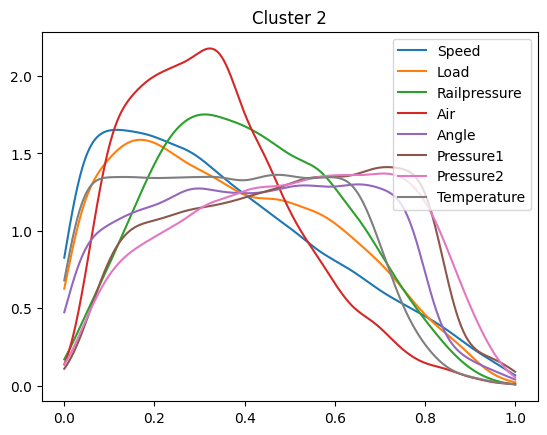

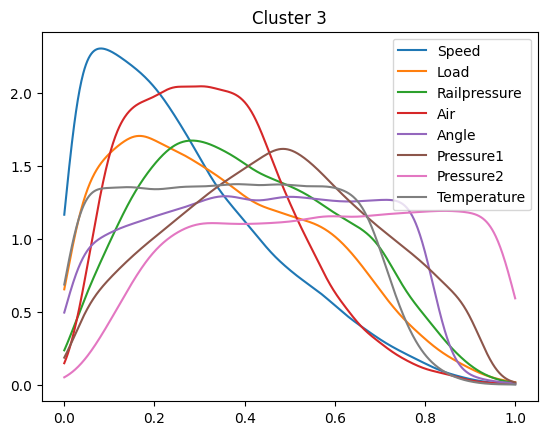

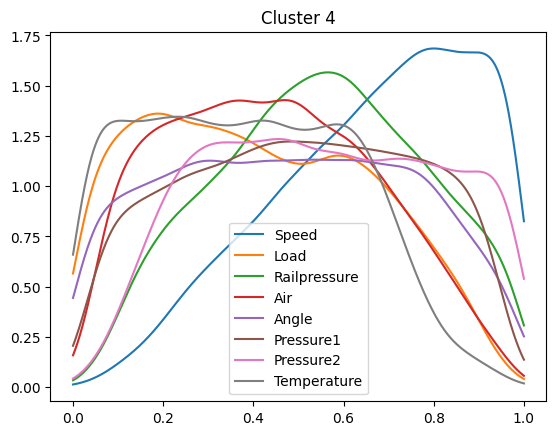

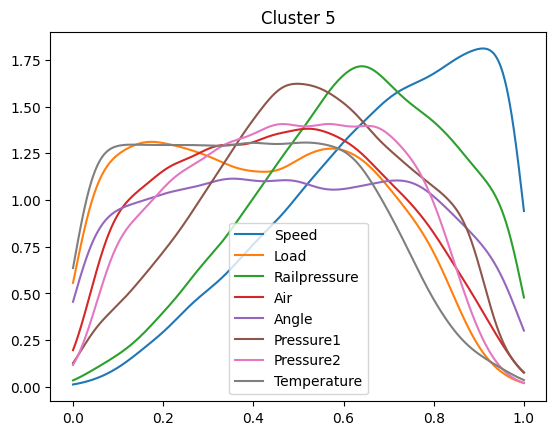

In [37]:
# normalize the cluster data in each cluster
normalizedClusters = []
for i in range(6):
    cluster = allClusters[i][1]
    # cluster drop last column (Type bool)
    cluster = cluster.drop(columns=['feasible'])
    min_value = allClusters[i][5]
    max_value = allClusters[i][6]
    for index, row in cluster.iterrows():
        for col in cluster.columns:  # Verwenden Sie die Spaltennamen direkt
            #print(type(row[col]))
            cluster.at[index, col] = (row[col] - min_value[col]) / (max_value[col] - min_value[col])
    normalizedClusters.append(cluster)

from scipy.stats import gaussian_kde

for j in range(6):
    # KDE-Instanz erstellen für jeden normalisierten Cluster
    cluster = normalizedClusters[j]
    
    # get the column names
    column_names = cluster.columns.values

    kdes = []
    densities = []
    values = np.linspace(0, 1, 1000)
    for i in range(8):
        kde = gaussian_kde(cluster.iloc[:, i])
        kdes.append(kde)
        densities.append(kde.evaluate(values))

    # Dichtefunktionen für die normalisierten Werte plotten
    for i in range(8):
        plt.plot(values, densities[i], label=cluster.columns.values[i])
        plt.title(f"Cluster {j}")
    plt.legend()
    plt.show()

In [38]:
# Find the percentages of size of the clusters in respect to the whole data submission
cluster_sizes = []
for i in range(6):
    cluster_size = allClusters[i][2]/len(submission)
    cluster_sizes.append(cluster_size)
    print(f"Cluster {i} size in %: {cluster_size*100}%")

Cluster 0 size in %: 16.639604781316937%
Cluster 1 size in %: 16.71388101983003%
Cluster 2 size in %: 17.251088233261935%
Cluster 3 size in %: 19.030263248808126%
Cluster 4 size in %: 14.20921716299316%
Cluster 5 size in %: 16.155945553789817%


In [39]:
# Generate new data points for each cluster based on the density function of each attribute
import math

def generate_new_data_points(nmbOfPoints):
    new_data = []
    new_data_strings = []
    for i in range(6):
        cluster = allClusters[i][1]
        new_data_points = []
        nmbPerCluster = math.ceil(cluster_sizes[i]*nmbOfPoints)
        # print("Number of new data points: ", nmbPerCluster)
        for j in range(8):
            kde = gaussian_kde(cluster.iloc[:, j])
            new_data_points.append(kde.resample(nmbPerCluster)[0])
        new_data_points = np.array(new_data_points).T
        new_data.append(new_data_points)
    return new_data 

new_data = generate_new_data_points(20)

for i in range(len(new_data)):
    print(new_data[i].shape)

(4, 8)
(4, 8)
(4, 8)
(4, 8)
(3, 8)
(4, 8)


In [40]:
# check new_data feasibility
feasibleDataPoints = []
for i in range(len(new_data)):
    for j in range(len(new_data[i])):
        #print(new_data[i][j])
        x1, x2, x3, x4, x5, x6, x7, x8 = new_data[i][j]
        # print(x1, x2, x3, x4, x5, x6, x7, x8)
        if is_feasible(x1, x2, x3, x4, x5, x6, x7, x8):
            feasibleDataPoints.append(new_data[i][j])

# print(feasibleDataPoints)
# for i in range(len(feasibleDataPoints)):
#     semicolon_seperated_string = ";".join(map(str, feasibleDataPoints[i]))
#     print(semicolon_seperated_string)

In [41]:
# check feasibleData safety via classifier
X = feasibleDataPoints
safeDataPoints = []
y_pred = clf.predict(X)
print(y_pred)

for i in range(len(y_pred)):
    if y_pred[i] == 0:
        safeDataPoints.append(X[i])

print(len(safeDataPoints) == len(y_pred[y_pred == 0]))

# print(feasibleDataPoints)
for i in range(len(feasibleDataPoints)):
    semicolon_seperated_string = ";".join(map(str, feasibleDataPoints[i]))
    print(semicolon_seperated_string)

[1 1 1 1 1 1 1 1 1 1 1 1]
True
1209.181692121653;38.69848478344159;1316.561132525162;546.5787301345238;1.2213551362656443;1549.2397599525104;1599.994641678293;56.85669644194619
1839.2358697898296;22.640197801144815;854.3383676012875;260.9872108989647;0.3201463255121283;1934.6282442107713;2355.3937621509613;45.679928002841194
2247.8509711811316;25.012221216098386;2464.776995911965;465.4265349997527;-3.745258441408081;2851.3739093501326;3249.828730155684;65.7415997002288
1628.943280347022;84.2181593096112;1994.218385536071;500.22553948810787;4.363301604238216;2888.8345334065752;3140.21872168619;59.17108024405732
1174.3425298894508;61.11896876552113;1146.024889182857;444.15289897886896;-1.4333203178010803;2451.74812787077;2478.5849721648146;57.98162714612946
1065.878004942629;31.74712192417418;1127.0518132474974;642.1018253732685;6.6091506403900695;2546.6794064584615;2300.485323922687;71.5220668235253
1229.203418333175;30.57955237962763;970.8439868324147;203.43952654318127;-5.009006947568

C:\Users\boeke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Next try: Gleichverteilung der Daten auf Speed and load, entnehme Slices aus submission